In [1]:
import os
import functools as ftools
import itertools as itools
import pandas as pd
import numpy as np

import sgml, dproc, sgnn, sgutil
import tensorflow as tf
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import dill

import seaborn as sns
import matplotlib.pyplot as plt

2024-11-18 10:04:45.848129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731924285.859643  109488 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731924285.863186  109488 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 10:04:45.875252: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.metrics import accuracy_score

In [3]:
with open(os.path.join('data', 'var_w.dill'), 'rb') as f:
    df_var = dill.load(f)
df_train = pd.read_feather(os.path.join('data', 'train_w.feather'))
sc = sgutil.SGCache('img', 'result')
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
ss = ShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
target = 'Depression'

In [4]:
def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction, stratify=x[target])

def print_metrics(title, m):
    print("Accuracy, {}: {:.5f}±{:.5f}".format(
        title, np.mean(m), np.std(m)
    ))

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index=df.index),
    'score_func': lambda df, prds: accuracy_score(df[target].sort_index(), prds.sort_index() > 0.5),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'y': target,
}

lgb_adapter = sgml.LGBMAdapter(model=lgb.LGBMClassifier)
xgb_adapter = sgml.XGBAdapter(model=xgb.XGBClassifier)
cb_adapter = sgml.CBAdapter(model=cb.CatBoostClassifier)

def show_result_lgb(result):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    sns.barplot(
        pd.concat([i['feature_importance'] for i in result['model_result']], axis=1).mean(axis=1)\
        .sort_values(ascending=False).rename('Importance').reset_index().rename(columns={'index':'feature'}),
        x = 'Importance', y = 'feature', ax=axes[0]
    )
    valid_result = pd.concat([i['valid_result'] for i in result['model_result']], axis=1).T.groupby(level=1).mean().T
    sns.lineplot(valid_result, ax=axes[1])
    if 'valid_1' in valid_result:
        axes[1].axvline(valid_result['valid_1'].idxmin())
    plt.tight_layout()
    plt.show()

# LGB1

In [5]:
cv_path = os.path.join('result', 'LGB1.cv')
if os.path.exists(cv_path):
    lgb1 = sgml.CVModel.load('result', 'LGB1')
else:
    lgb1 = sgml.CVModel('result', 'LGB1', skf, config, lgb_adapter)

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

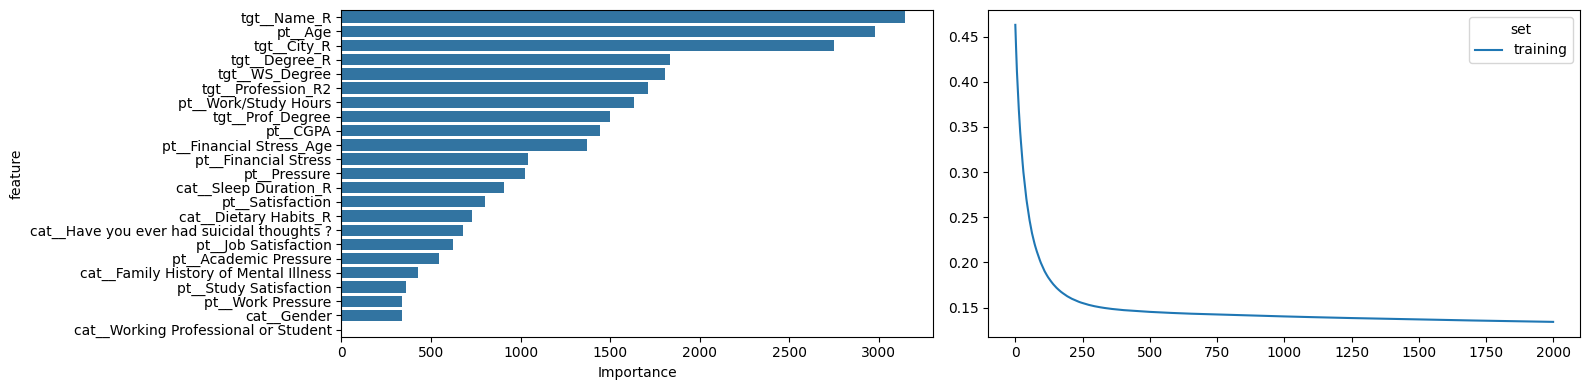

[0.9377398720682303]


In [152]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 15,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.7,
        'min_child_samples': 4096
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R']
}
# result = lgb1.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['valid_scores'])

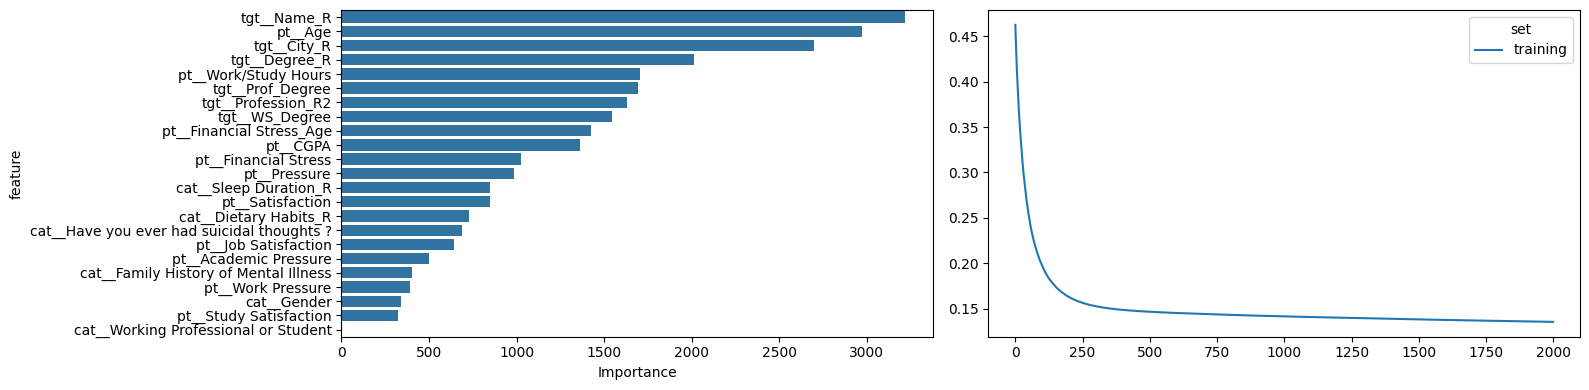

Accuracy, Valid.: 0.93968±0.00158


In [153]:
result = lgb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'num_leaves': 31, 'learning_rate': 0.005, 'random_state': 123, 'colsample_bytree': 0.7, 'min_child_samples': 4096}"
X_tgt,[Name_R]
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Degree_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Profession_R2, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


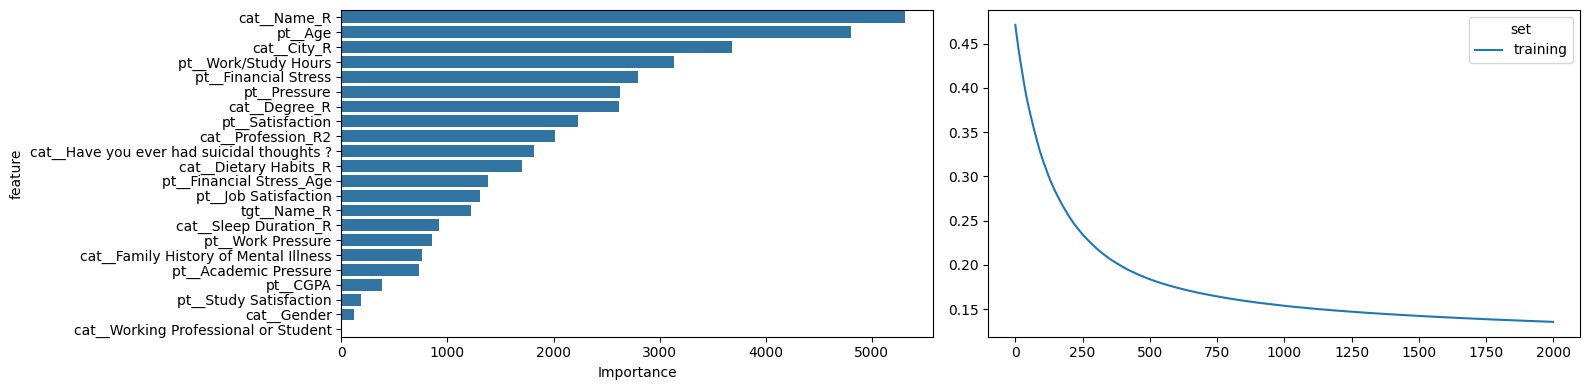

0.9396872778962331


In [123]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(lgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(lgb1.get_best_result())
print(lgb1.cv_best_['score'])

# XGB1

In [10]:
cv_path = os.path.join('result', 'XGB1.cv')
if os.path.exists(cv_path):
    xgb1 = sgml.CVModel.load('result', 'XGB1')
else:
    xgb1 = sgml.CVModel('result', 'XGB1', skf, config, xgb_adapter)

In [76]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'max_depth': 3,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.25,
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R']
}
# xgb1.adhoc(df_train, ss, hparams)

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

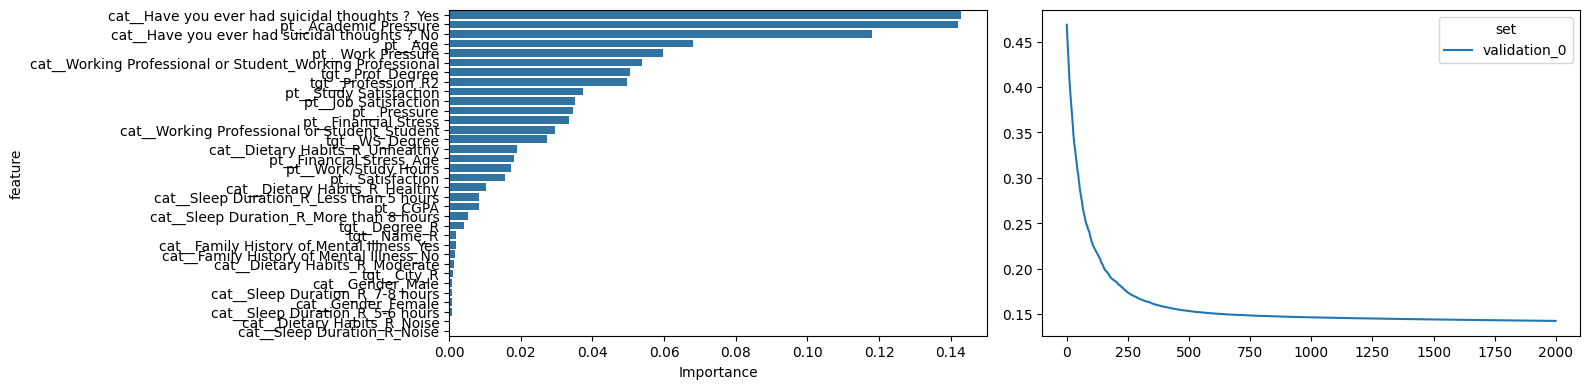

Accuracy, Valid.: 0.93979±0.00162


In [77]:
result = xgb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

,value
model_params,"{'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.02, 'random_state': 123, 'colsample_bytree': 0.25}"
X_tgt,"[Name_R, City_R, Prof_Degree, WS_Degree, Profession_R2, Degree_R]"
X_num,"[CGPA, Pressure, Satisfaction, Work/Study Hours, Work Pressure, Academic Pressure, Study Satisfaction, Job Satisfaction, Age, Financial Stress, Financial Stress_Age]"
X_cat,"[Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness, Sleep Duration_R, Dietary Habits_R]"


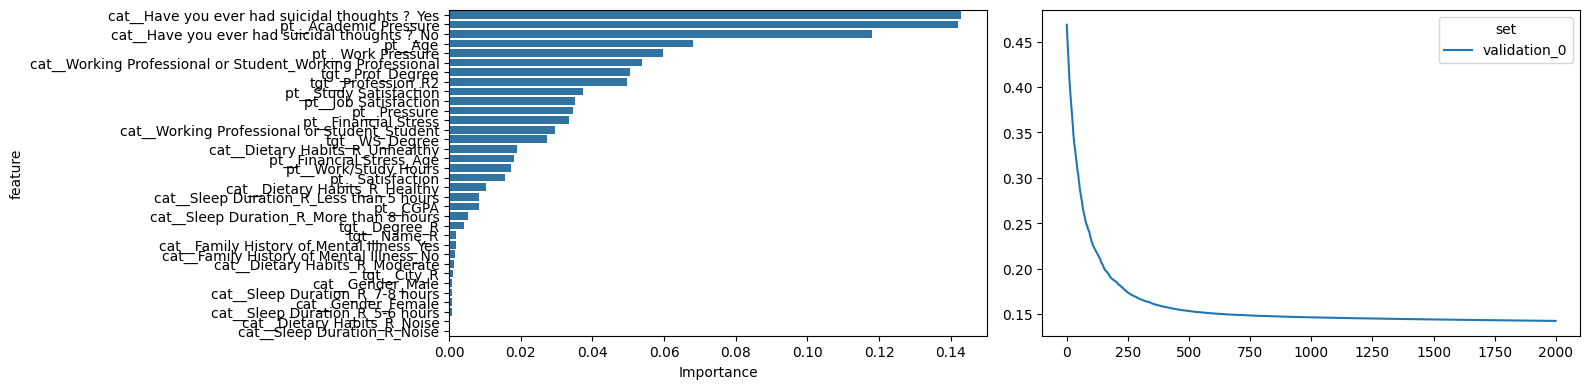

0.9397867803837953


In [79]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(xgb1.cv_best_['hparams']).rename('value').to_frame())
show_result_lgb(xgb1.get_best_result())
print(xgb1.cv_best_['score'])

# CB

In [14]:
cv_path = os.path.join('result', 'CB1.cv')
if os.path.exists(cv_path):
    cb1 = sgml.CVModel.load('result', 'CB1')
else:
    cb1 = sgml.CVModel('result', 'CB1', skf, config, cb_adapter)

In [15]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'max_depth': 5,
        'learning_rate': 0.05,
        'random_state' : 123,
    }, 
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R',
              'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R']
}
# cb1.adhoc(df_train, ss, hparams)

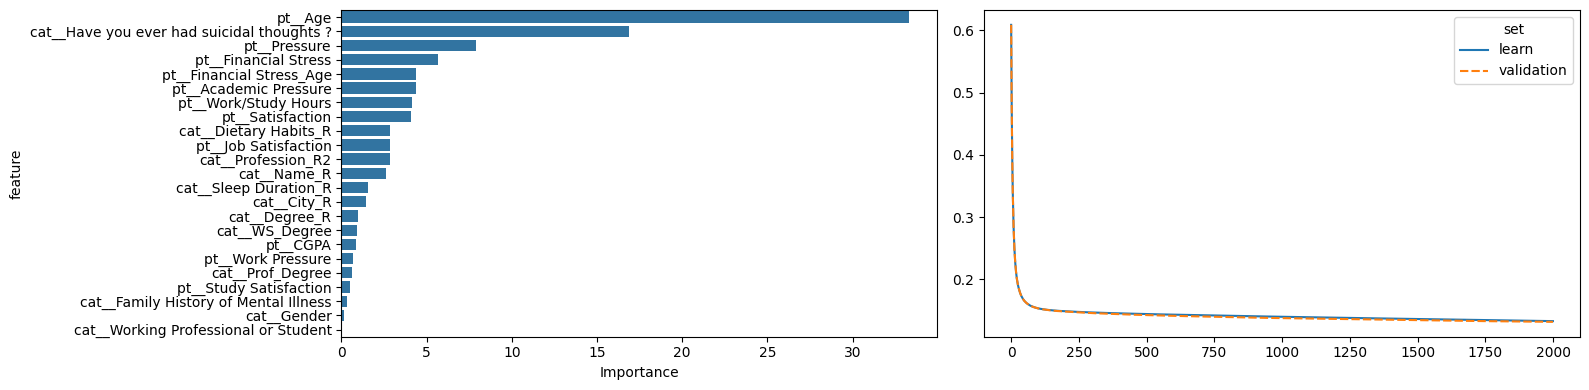

Accuracy, Valid.: 0.94016±0.00180


In [16]:
result = cb1.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

# NN

In [17]:
import importlib
import sgnn
importlib.reload(sgnn)

<module 'sgnn' from '/home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep11/sgnn.py'>

In [18]:
class DepressionModel(tf.keras.Model):
    def __init__(self, emb_cols, cont_cols, f_size, left_layers, right_layers, top_layers):
        super().__init__()
        if emb_cols != None:
            self.emb_layers = {
                v.replace(' ', '_').replace('?', '_'): tf.keras.layers.Embedding(c, s, name=v.replace(' ', '_').replace('?', '_')) for v, c, s in emb_cols
            }
            self.emb_cc = tf.keras.layers.Concatenate(axis=-1)
            if left_layers != None:
                self.left_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dense(**params) for params in left_layers
                ])
                self.right_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dense(**params) for params in right_layers
                ])
                self.mul = tf.keras.layers.Multiply()
                self.left_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.left_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
                self.right_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.right_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
            else:
                self.left_model = None
        else:
            self.emb_layers = None
        self.top_cc = tf.keras.layers.Concatenate(axis=-1)
        self.top_model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(**params) for params in top_layers
        ])
        self.f_size = f_size
        self.cont_cols = cont_cols
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def __call__(self, X):
        if self.emb_layers != None:
            X_emb = self.emb_cc([tf.squeeze(v(X[k]), axis=-2) for k, v in self.emb_layers.items()])
            if self.left_model !=None:
                X_left = self.left_model(X_emb)
                X_right = self.right_model(X_emb)
                X_left_1 = self.left_slice_layer_1(X_left)
                X_left_2 = self.left_slice_layer_2(X_left)
                
                X_right_1 = self.right_slice_layer_1(X_right)
                X_right_2 = self.right_slice_layer_2(X_right)
                X_mul = self.mul([X_left_1, X_right_1])
                cc_list = [X_left_2, X_right_2, X_mul]
            else:
                cc_list = [X_emb]
        else:
            cc_list = list()
        if self.cont_cols != None:
            cc_list.append(X[self.cont_cols])
        if len(cc_list) == 1:
            return self.sigmoid(
                self.top_model(cc_list[0])
            )
        else:
            return self.sigmoid(
                self.top_model(self.top_cc(cc_list))
            )

def to_tf_dataset(X, Y=None, sample_weights=None, cont=[], cat=[]):
    d = {}
    c = 0
    for i in cat:
        d[i.replace(' ', '_').replace('?', '_')] = np.expand_dims(X[:, c].astype('int'), axis=-1)
        c += 1
        
    if len(cont) > 0:
        d['Continous'] =  X[:, c:]
    if Y is None:
        return tf.data.Dataset.from_tensor_slices(d)
    else:
        if type(Y) == pd.Series:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y.values))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y.values, sample_weights.values))
        else:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y, sample_weights))

def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size


X_cat = ['Name_R', 'City_R', 'Profession_R2', 'Degree_R', 'Sleep Duration_R', 'Dietary Habits_R', 
         'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness']
X_num = ['CGPA_FZ', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure_FZ', 'Academic Pressure_FZ', 
         'Study Satisfaction_FZ', 'Job Satisfaction_FZ', 'Age', 'Financial Stress_FM', 'Financial Stress_Age']
X_nn_emb = [
    ('Name_R', 4), ('City_R', 3), ('Profession_R2', 3), ('Degree_R', 3), ('Sleep Duration_R', 2), ('Dietary Habits_R', 2), ('Working Professional or Student', 1), 
    ('Have you ever had suicidal thoughts ?', 1), ('Gender', 1), ('Family History of Mental Illness', 1)
]

nn_adapter = sgnn.NNAdapter(
    model=sgnn.NNClassifier,
    to_tf_dataset = ftools.partial(
        to_tf_dataset, 
        cont=X_num,
        cat=X_cat
    )
)

In [20]:
cv_path = os.path.join('result', 'NN1.cv')
if os.path.exists(cv_path):
    nn1 = sgml.CVModel.load('result', 'NN1')
else:
    nn1 = sgml.CVModel('result', 'NN1', skf, config, nn_adapter)

In [157]:
nn_params = {
    'emb_cols': [
        nn_cat_param(df_train, v, n) for v, n in X_nn_emb
    ], 
    'cont_cols':  'Continous',
    'f_size':  16, 
    'left_layers': [
        {'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        #{'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 32, 'kernel_initializer': 'glorot_uniform'}
    ], 
    'right_layers': [
        {'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        #{'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 16, 'kernel_initializer': 'glorot_uniform'}
    ], 
    'top_layers': [
        {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 16, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
        {'units': 1, 'kernel_initializer': 'glorot_uniform'}
    ]
}

hparams = {
    'model_params': {
        'model': DepressionModel, 
        'model_params': nn_params,
        'epochs': 20,
        'optimizer': ('Adam', {'learning_rate': 0.0003}),
        'batch_size': 512, 'shuffle_size': 102400,
        'early_stopping': None, 'reduce_lr_on_plateau': None, 'lr_scheduler': None
    }, 
    'X_std': X_num,
    'X_cat': X_cat,
    'ohe_drop': 'first'
}
#nn1.adhoc(df_train, ss, hparams)

In [158]:
result = nn1.cv(df_train, hparams)
print_metrics('Valid.', result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Step:   0%|          | 0/220 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Step:   0%|          | 0/220 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Step:   0%|          | 0/220 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Step:   0%|          | 0/220 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Step:   0%|          | 0/220 [00:00<?, ?it/s]

Accuracy, Valid.: 0.93915±0.00150


In [159]:
with pd.option_context('display.max_colwidth', 500):
    display(pd.Series(nn1.cv_best_['hparams']).rename('value').to_frame())
print(nn1.cv_best_['score'])

,value
model_params,"{'model': <class '__main__.DepressionModel'>, 'model_params': {'emb_cols': [('Name_R', 218, 4), ('City_R', 31, 3), ('Profession_R2', 38, 3), ('Degree_R', 28, 3), ('Sleep Duration_R', 5, 2), ('Dietary Habits_R', 4, 2), ('Working Professional or Student', 2, 1), ('Have you ever had suicidal thoughts ?', 2, 1), ('Gender', 2, 1), ('Family History of Mental Illness', 2, 1)], 'cont_cols': 'Continous', 'f_size': 16, 'left_layers': [{'units': 64, 'activation': 'relu', 'kernel_initializer': 'he_unifo..."
X_std,"[CGPA_FZ, Pressure, Satisfaction, Work/Study Hours, Work Pressure_FZ, Academic Pressure_FZ, Study Satisfaction_FZ, Job Satisfaction_FZ, Age, Financial Stress_FM, Financial Stress_Age]"
X_cat,"[Name_R, City_R, Profession_R2, Degree_R, Sleep Duration_R, Dietary Habits_R, Working Professional or Student, Have you ever had suicidal thoughts ?, Gender, Family History of Mental Illness]"
ohe_drop,first


0.9391542288557215


# LGB + LDA

In [182]:
cv_path = os.path.join('result', 'LGB_LDA.cv')
if os.path.exists(cv_path):
    lgb_lda = sgml.CVModel.load('result', 'LGB_LDA')
else:
    lgb_lda = sgml.CVModel('result', 'LGB_LDA', skf, config, lgb_adapter)

In [235]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 7,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.9,
        'min_child_samples': 1024
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R'],
    'X_num': ['CGPA', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R'],
    'lda' : {
        'X_mm': ["Pressure", "Satisfaction", "Work/Study Hours", "Age", "Financial Stress_FM"],
        'X_ohe': ['Have you ever had suicidal thoughts ?'],
        'ohe_drop': 'first'
    }
}
# result = lgb_lda.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

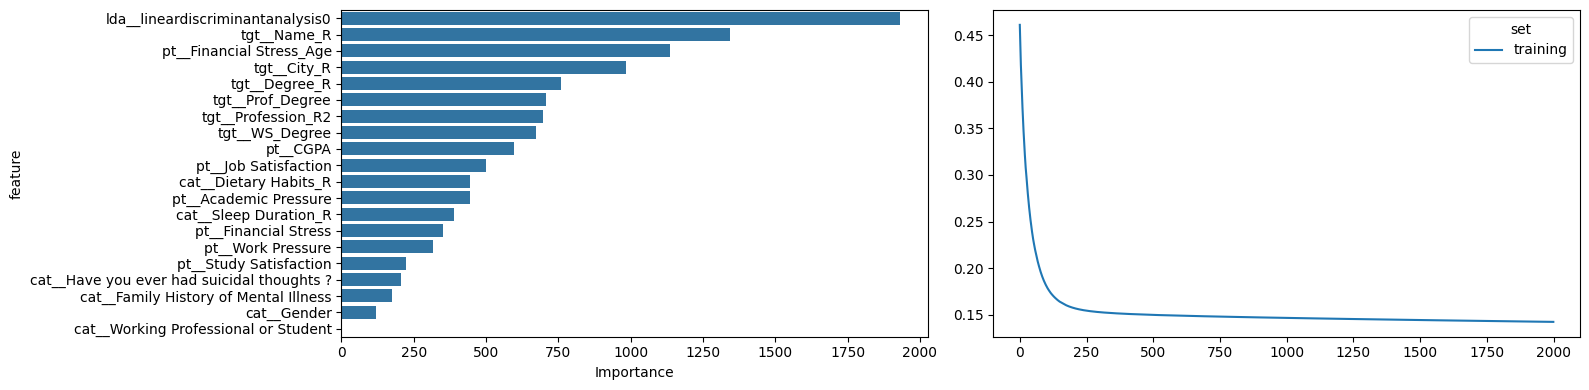

Accuracy, Valid.: 0.93911±0.00161


In [225]:
result = lgb_lda.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

# LGB2

In [232]:
cv_path = os.path.join('result', 'LGB2.cv')
if os.path.exists(cv_path):
    lgb2 = sgml.CVModel.load('result', 'LGB2')
else:
    lgb2 = sgml.CVModel('result', 'LGB2', skf, config, lgb_adapter)

In [236]:
hparams = {
    'model_params': {
        'n_estimators': 2000, 
        'num_leaves': 7,
        'learning_rate': 0.02,
        'random_state' : 123,
        'colsample_bytree' : 0.7,
        'min_child_samples': 2048
    }, 
    'X_tgt': ['Name_R', 'City_R', 'Prof_Degree', 'WS_Degree', 'Profession_R2', 'Degree_R'],
    'X_num': ['CGPA', 'Pressure', 'Satisfaction', 'Work/Study Hours', 'Work Pressure', 'Academic Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Age', 'Financial Stress', 'Financial Stress_Age'],
    'X_cat': ['Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Gender', 'Family History of Mental Illness', 'Sleep Duration_R', 'Dietary Habits_R']
}
# result = lgb2.adhoc(df_train, ss, hparams)
# show_result_lgb(result)
# print(result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

Round:   0%|          | 0/2000 [00:00<?, ?it/s]

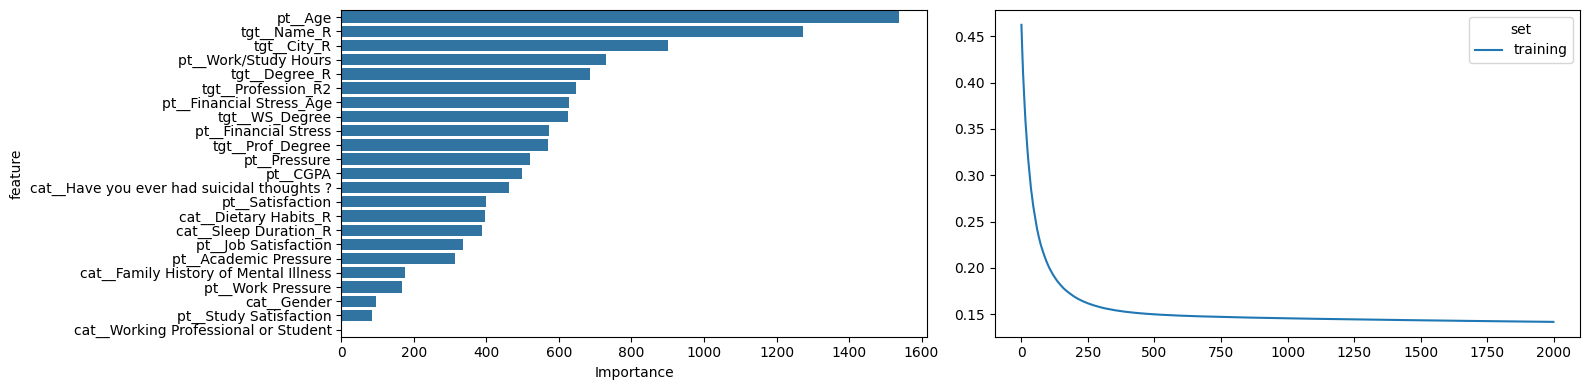

Accuracy, Valid.: 0.93988±0.00123


In [234]:
result = lgb2.cv(df_train, hparams)
show_result_lgb(result)
print_metrics('Valid.', result['valid_scores'])

# Stacking

In [237]:
df_stk = sgml.stack_cv([lgb1, xgb1, cb1, nn1, lgb_lda, lgb2], df_train[target]).sort_index()
df_stk.corr()

,LGB1,XGB1,CB1,NN1,LGB_LDA,LGB2,Depression
LGB1,1.000000,0.994190,0.993208,0.991640,0.992318,0.994254,0.837802
XGB1,0.994190,1.000000,0.996566,0.990101,0.997503,0.998435,0.838713
CB1,0.993208,0.996566,1.000000,0.989886,0.995544,0.995797,0.839179
NN1,0.991640,0.990101,0.989886,1.000000,0.989810,0.989322,0.835557
LGB_LDA,0.992318,0.997503,0.995544,0.989810,1.000000,0.997287,0.838017
LGB2,0.994254,0.998435,0.995797,0.989322,0.997287,1.000000,0.838230
Depression,0.837802,0.838713,0.839179,0.835557,0.838017,0.838230,1.000000


In [238]:
from sklearn.linear_model import LogisticRegression

In [239]:
lr_adapter = sgml.SklearnAdapter(LogisticRegression)

In [240]:
stk = sgml.CVModel('result', 'stk_lr', skf, config, lr_adapter)

In [250]:
hparams={
    'model_params' : {'C': 10},
    'X_num':['XGB1', 'CB1', 'LGB1', 'NN1', 'LGB_LDA', 'LGB2']
}
# stk.adhoc(df_stk, ss, hparams)

In [251]:
result = stk.cv(df_stk, hparams)
print_metrics('Valid. score', result['valid_scores'])

Accuracy, Valid. score: 0.94041±0.00167


In [246]:
accuracy_score(df_stk[target], (df_stk[['LGB1', 'XGB1', 'CB1', 'NN1', 'LGB_LDA', 'LGB2']].mean(axis=1) > 0.5))

0.940227434257285

In [255]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df_stk[target], df_stk['CB1'])

0.9758899940410526

In [254]:
roc_auc_score(df_stk[target], df_stk[['LGB1', 'XGB1', 'CB1', 'NN1', 'LGB_LDA', 'LGB2']].mean(axis=1))

0.976178290154665